# Regression

In [140]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
import statsmodels.formula.api as sm
import statsmodels.api as sma
import seaborn as sns
from sklearn import linear_model
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

from tools import *

In [141]:
db = pd.read_csv("data/player_stats_extended.csv")
db = db_to_numeric(db)

db.head()

,PLAYER_ID,PLAYER_NAME,SEASON,SEASON_NUM,AGE,PLAYER_HEIGHT_INCHES,PLAYER_WEIGHT,GP,MIN,USG_PCT,...,AVG_DRIB_PER_TOUCH,ELBOW_TOUCHES,POST_TOUCHES,PAINT_TOUCHES,TEAM,INJURED ON,RETURNED,DAYS MISSED,INJURED_TYPE,INJURY_SEVERITY
0,1630639,A.J. Lawson,22-23,22.5,22.0,78.0,179.0,13,4.8,0.182,...,0.62,0.0,0.0,0.2,NaN,NaN,NaN,NaN,NaN,NaN
1,1631260,AJ Green,22-23,22.5,23.0,77.0,190.0,32,9.4,0.160,...,1.84,0.1,0.0,0.3,NaN,NaN,NaN,NaN,NaN,NaN
2,1631100,AJ Griffin,22-23,22.5,19.0,78.0,220.0,66,19.4,0.174,...,1.49,0.4,0.0,0.7,NaN,NaN,NaN,NaN,NaN,NaN
3,203932,Aaron Gordon,22-23,22.5,27.0,80.0,235.0,61,30.1,0.206,...,2.11,1.8,2.1,6.8,Nuggets,NaN,2023-02-07,5.0,Sprained_ankle,Moderate
4,1628988,Aaron Holiday,22-23,22.5,26.0,72.0,185.0,57,13.7,0.128,...,3.82,0.1,0.0,0.4,NaN,NaN,NaN,NaN,NaN,NaN


## Number of injuries and age

### Scatter plots

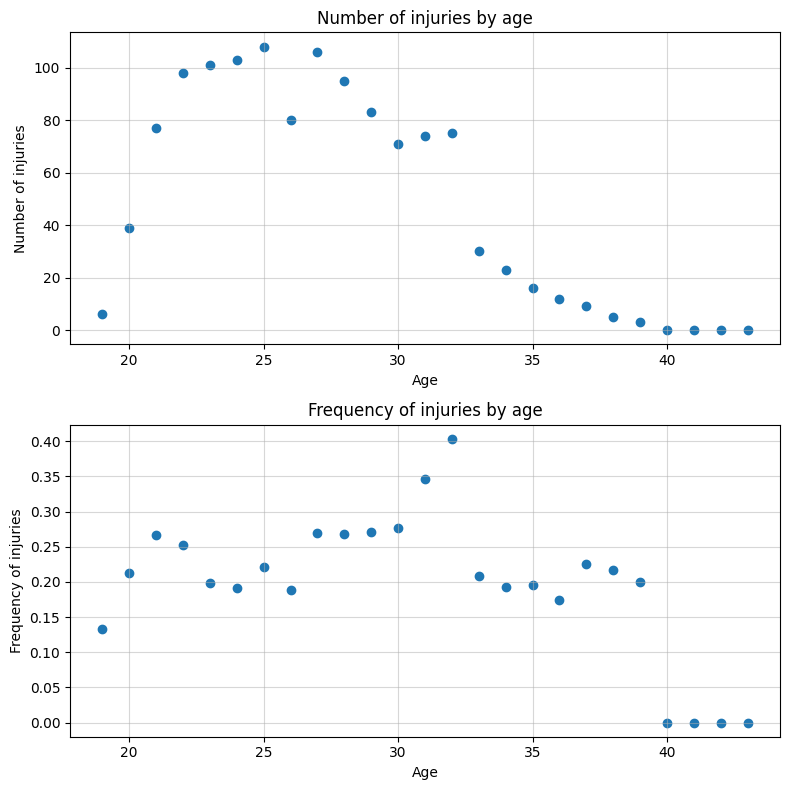

In [142]:
# db that contains the number of injuries for each age
injuries_age = pd.DataFrame([
    {
    'Age': int(a), 
    'injuries_number': len(db[(db["AGE"] == a) & (~db["INJURED_TYPE"].isna())]),
    'unique_players': len(db[db["AGE"] == a]["PLAYER_ID"].unique())
    }
    for a in sorted(db["AGE"].unique())
])

fig, ax = plt.subplots(2, 1, figsize=(8, 8))

ax[0].scatter(injuries_age["Age"], injuries_age["injuries_number"])
ax[0].set_xlabel("Age")
ax[0].set_ylabel("Number of injuries")
ax[0].set_title("Number of injuries by age")
ax[0].grid(alpha=0.5)

ax[1].scatter(injuries_age["Age"], injuries_age["injuries_number"] / injuries_age["unique_players"])
ax[1].set_xlabel("Age")
ax[1].set_ylabel("Frequency of injuries")
ax[1].set_title("Frequency of injuries by age")
ax[1].grid(alpha=0.5)

plt.tight_layout()
plt.show()

This already doesn't look especially promising: the trend that the first graph (Number of injuries by age) shows is most probably influenced by the different age distribution in the dataset (as in the graph below).

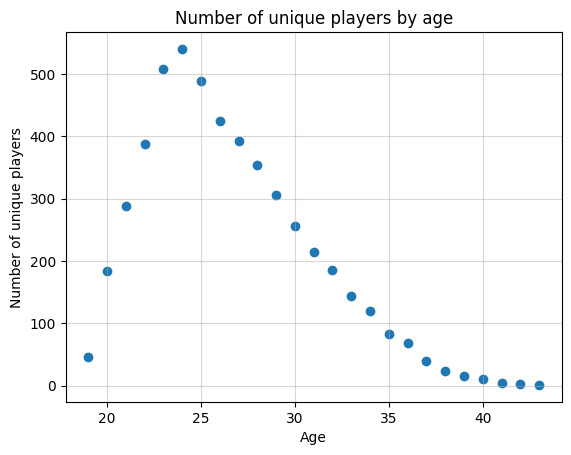

In [143]:
plt.scatter(injuries_age["Age"], injuries_age["unique_players"])
plt.xlabel("Age")
plt.ylabel("Number of unique players")
plt.title("Number of unique players by age")
plt.grid(alpha=0.5)
plt.show()

### Linear regression

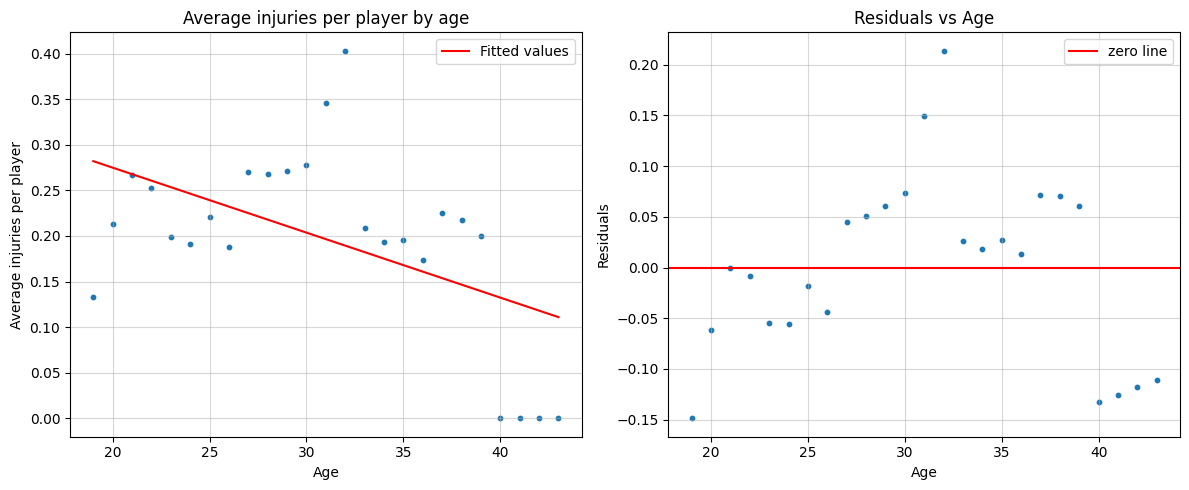

In [144]:
injuries_age_stats = pd.DataFrame({
    'Age': injuries_age['Age'],
    'injuries_ratio': injuries_age['injuries_number']/injuries_age['unique_players']
})

res = sm.ols('injuries_ratio ~ Age', data=injuries_age_stats).fit()
residuals = res.resid

summary = plot_linear_regression(injuries_age_stats, res, residuals)

In [145]:
print(summary)

                            OLS Regression Results                            
Dep. Variable:         injuries_ratio   R-squared:                       0.257
Model:                            OLS   Adj. R-squared:                  0.224
Method:                 Least Squares   F-statistic:                     7.946
Date:                Tue, 06 May 2025   Prob (F-statistic):            0.00974
Time:                        21:13:35   Log-Likelihood:                 25.447
No. Observations:                  25   AIC:                            -46.89
Df Residuals:                      23   BIC:                            -44.46
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4175      0.080      5.188      0.0

## Multiple regression on number of injuries

We aim to find the attributes that best predicts number of injuries among players

In [146]:
injuries_multiple = pd.DataFrame([
    {
        'injuries_number': len(db[db["AGE"] == a]),
        'games_played': db[db["AGE"] == a]["GP"].sum(),
        'minutes': db[db["AGE"] == a]["MIN"].mean(),
    }
    for a in sorted(db["AGE"].unique())
])

train_data, test_data = train_test_split(injuries_multiple, test_size=0.2, random_state=42)

res_train = sm.ols('injuries_number ~ games_played + minutes', data=train_data).fit()
res_test = sm.ols('injuries_number ~ games_played + minutes', data=test_data).fit()

print(res_train.summary())

                            OLS Regression Results                            
Dep. Variable:        injuries_number   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     865.6
Date:                Tue, 06 May 2025   Prob (F-statistic):           7.88e-18
Time:                        21:13:35   Log-Likelihood:                -87.457
No. Observations:                  20   AIC:                             180.9
Df Residuals:                      17   BIC:                             183.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       89.7531     29.389      3.054   

In [147]:
print(res_test.summary())

                            OLS Regression Results                            
Dep. Variable:        injuries_number   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.998
Method:                 Least Squares   F-statistic:                     1261.
Date:                Tue, 06 May 2025   Prob (F-statistic):           0.000793
Time:                        21:13:35   Log-Likelihood:                -14.761
No. Observations:                   5   AIC:                             35.52
Df Residuals:                       2   BIC:                             34.35
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        4.4983     17.744      0.254   

/Users/luciocanepa/Library/CloudStorage/OneDrive-UniversitätZürichUZH/Intro to Data Science/data_science_project/venv/lib/python3.12/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 5 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


**Multiple regression plot (train data)**

In [148]:
y_pred = res_test.predict(test_data)
mse = np.mean((test_data['injuries_number'] - y_pred) ** 2)
rmse = np.sqrt(mse)

print(f"R-squared (coefficient of determination): {res_test.rsquared:.4f}")
print(f"Mean Squared Error: {mse:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")

print(f"Mean of injuries number: {np.mean(injuries_multiple['injuries_number'])}")
print(f"Min of injuries number: {np.min(injuries_multiple['injuries_number'])}, Max of injuries number: {np.max(injuries_multiple['injuries_number'])}")
print(f"Median of injuries number: {np.median(injuries_multiple['injuries_number'])}")
print(f"Standard deviation of injuries number: {np.std(injuries_multiple['injuries_number'])}")
print(f"Variance of injuries number: {np.var(injuries_multiple['injuries_number'])}")

R-squared (coefficient of determination): 0.9992
Mean Squared Error: 21.4672
Root Mean Squared Error: 4.6333
Mean of injuries number: 223.12
Min of injuries number: 1, Max of injuries number: 586
Median of injuries number: 189.0
Standard deviation of injuries number: 190.57288789332026
Variance of injuries number: 36318.02560000001


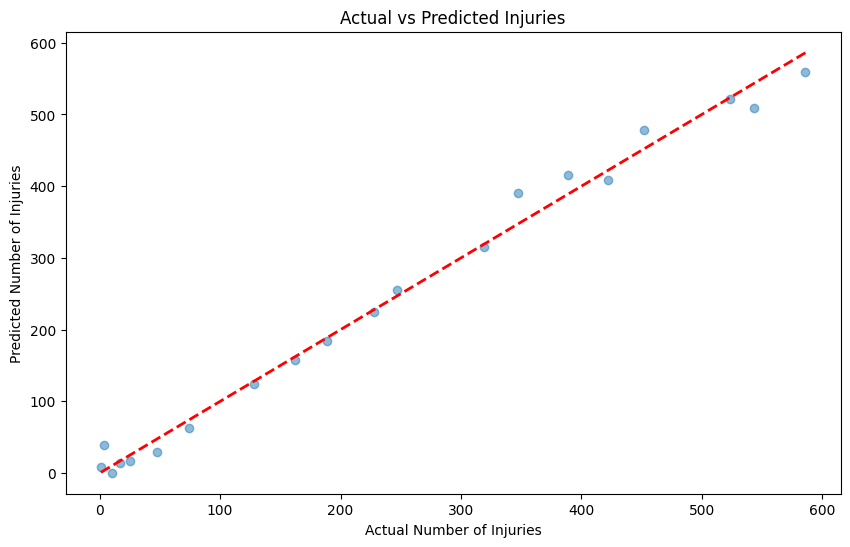

In [149]:
plot_multiple_regression(train_data, res_train)

**partial regression plot (train data)**

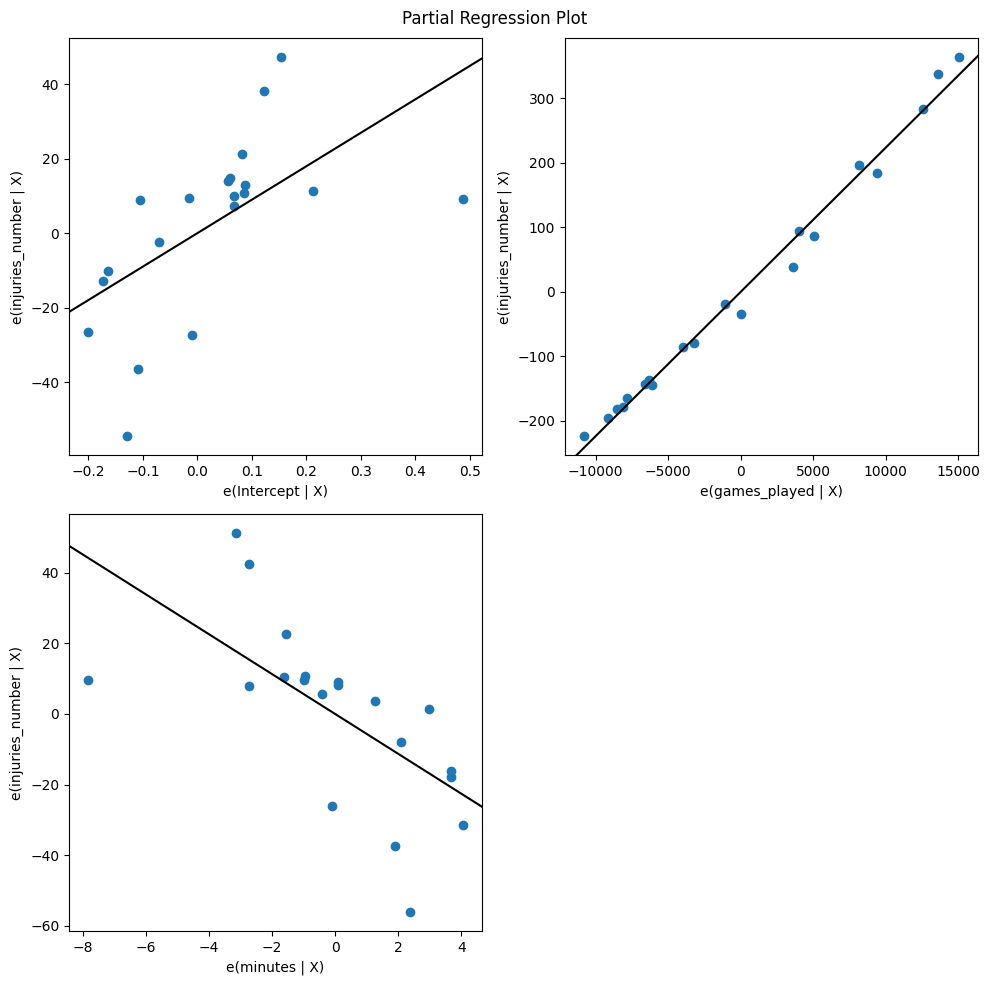

In [150]:
plot_partial_regression(res_train)

**Multiple regression plot (test)**

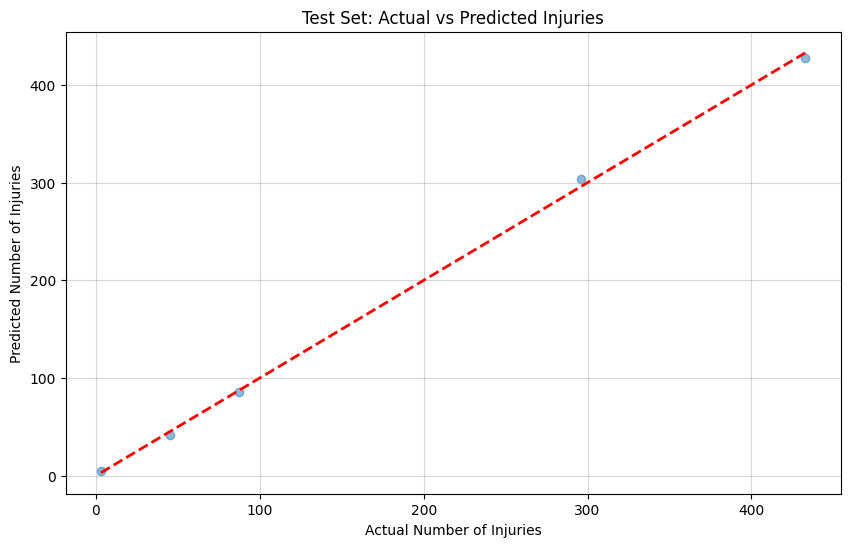

In [151]:
plot_multiple_regression_test(test_data, res_test.predict(test_data))

**Partial regression plot (test data)**

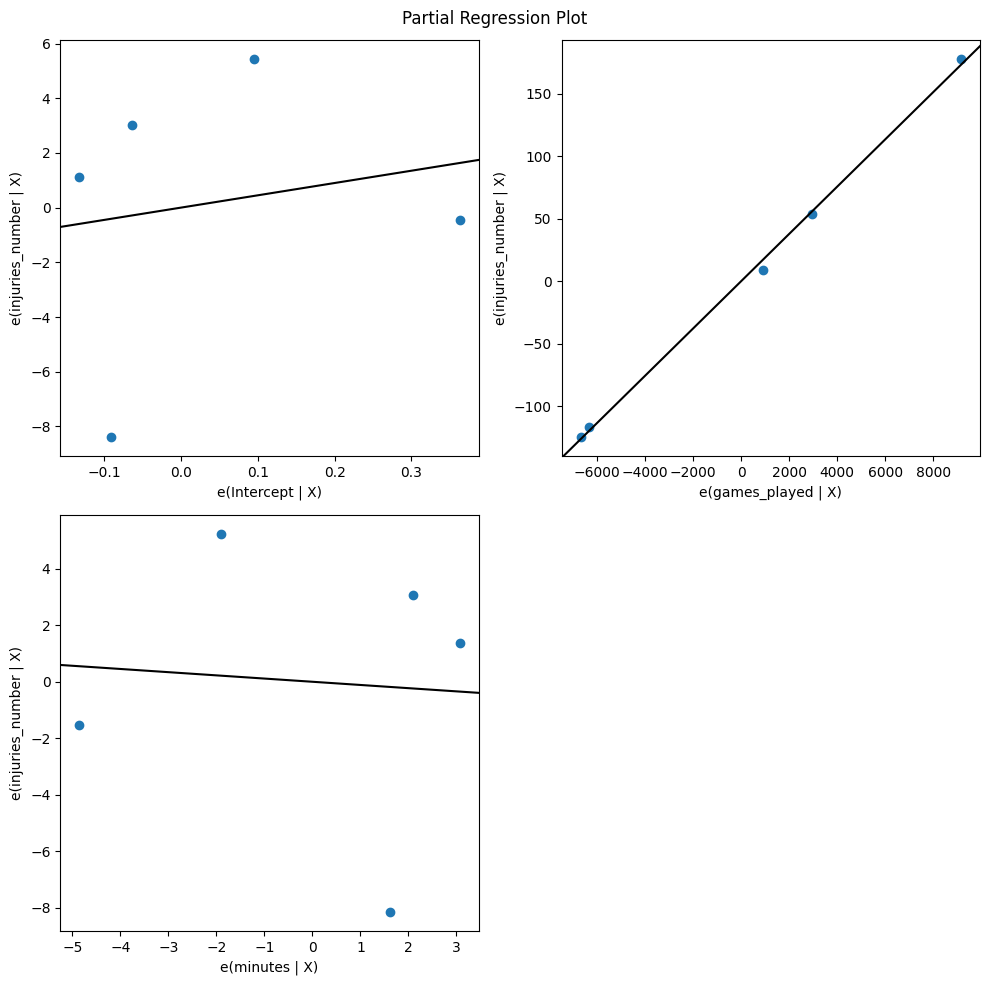

In [152]:
plot_partial_regression(res_test)

## Logistic regression

In [153]:
# Create the dataset
injuries_multiple_outcome = pd.DataFrame([
    {
        'has_injuries': len(db[(db["PLAYER_ID"] == p) & (db["INJURED_TYPE"].notna())]) > 0,
        'games_played': db[db["PLAYER_ID"] == p]["GP"].sum(),
        'minutes': db[db["PLAYER_ID"] == p]["MIN"].mean(),
    }
    for p in db["PLAYER_ID"].unique()
])

print("Class distribution:")
print(injuries_multiple_outcome['has_injuries'].value_counts())

Class distribution:
has_injuries
False    994
True     397
Name: count, dtype: int64


In [154]:
# Split data into train and test sets
train_data, test_data = train_test_split(injuries_multiple_outcome, test_size=0.2, random_state=42)

# Prepare features and target for training
X_train = train_data[['games_played', 'minutes']]
y_train = train_data['has_injuries']

# Prepare features and target for testing 
X_test = test_data[['games_played', 'minutes']]
y_test = test_data['has_injuries']

# Fit logistic regression model
lm = linear_model.LogisticRegression(solver='lbfgs')
lm.fit(X_train, y_train)

# Make predictions on both train and test sets
train_probabilities = lm.predict_proba(X_train)
train_pred = lm.predict(X_train)
test_probabilities = lm.predict_proba(X_test)
test_pred = lm.predict(X_test)

# Add predictions to dataframes
train_data['predicted_prob'] = train_probabilities[:, 1]
train_data['predicted'] = train_pred
test_data['predicted_prob'] = test_probabilities[:, 1]
test_data['predicted'] = test_pred

# Calculate accuracy score on test data
test_accuracy = accuracy_score(y_test, test_pred)
print(f"Test accuracy: {test_accuracy:.4f}")

train_data.head()

Test accuracy: 0.7993


,has_injuries,games_played,minutes,predicted_prob,predicted
743,True,24,9.650,0.076928,False
462,True,310,21.350,0.447115,False
984,False,256,15.760,0.319947,False
677,False,289,16.975,0.378411,False
1160,False,148,16.250,0.190203,False


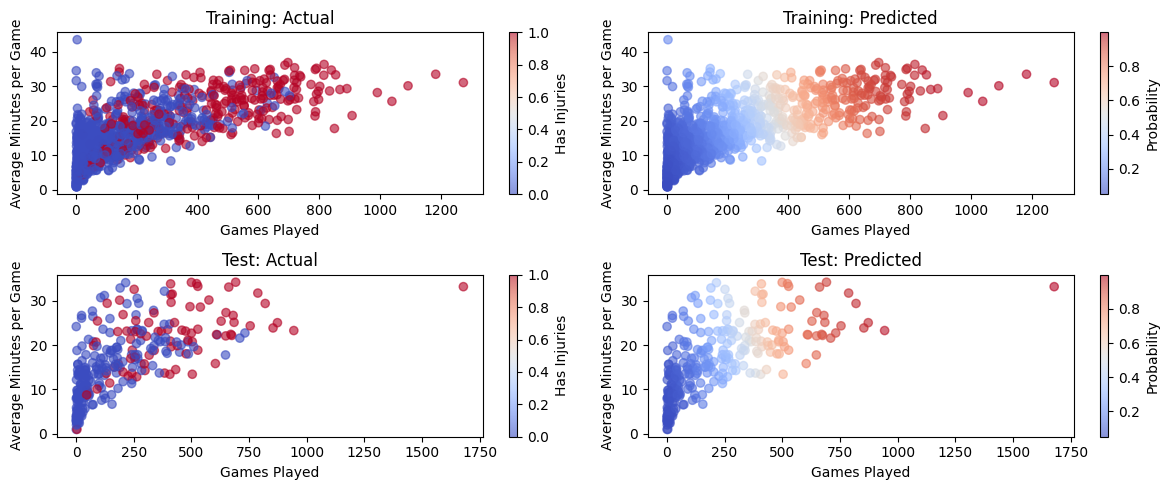

In [155]:
# Create a figure with four subplots in 2x2 layout
plt.figure(figsize=(12, 5))

# Plot 1: Training data scatter plot - Actual injuries
plt.subplot(221)
plt.scatter(train_data['games_played'], 
           train_data['minutes'],
           c=train_data['has_injuries'],
           cmap='coolwarm', 
           alpha=0.6)
plt.xlabel('Games Played')
plt.ylabel('Average Minutes per Game') 
plt.title('Training: Actual')
plt.colorbar(label='Has Injuries')

# Plot 2: Training data scatter plot - Predicted probabilities
plt.subplot(222)
plt.scatter(train_data['games_played'],
           train_data['minutes'], 
           c=train_data['predicted_prob'],
           cmap='coolwarm',
           alpha=0.6)
plt.xlabel('Games Played')
plt.ylabel('Average Minutes per Game')
plt.title('Training: Predicted')
plt.colorbar(label='Probability')

# Plot 3: Test data scatter plot - Actual injuries
plt.subplot(223)
plt.scatter(test_data['games_played'],
           test_data['minutes'],
           c=test_data['has_injuries'], 
           cmap='coolwarm',
           alpha=0.6)
plt.xlabel('Games Played')
plt.ylabel('Average Minutes per Game')
plt.title('Test: Actual')
plt.colorbar(label='Has Injuries')

# Plot 4: Test data scatter plot - Predicted probabilities
plt.subplot(224)
plt.scatter(test_data['games_played'],
           test_data['minutes'],
           c=test_data['predicted_prob'],
           cmap='coolwarm', 
           alpha=0.6)
plt.xlabel('Games Played')
plt.ylabel('Average Minutes per Game')
plt.title('Test: Predicted')
plt.colorbar(label='Probability')

plt.tight_layout()
plt.show()
